## Análisis Predictivo de Incumplimiento de Pago
El siguiente código en Python predice la probabilidad de que un cliente incumpla con sus pagos, utilizando el archivo `BD_bancaria.csv`. El objetivo es identificar clientes de alto riesgo para optimizar decisiones crediticias. Se implementan modelos de Regresión Logística, Árboles de Decisión y Random Forest, con un Análisis Exploratorio de Datos (EDA) robusto y limpieza de datos. Se prioriza la métrica AUC debido al posible desbalanceo en la variable objetivo (`IncumplimientoPago`).

In [2]:
# Impotación de Librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from ydata_profiling import ProfileReport

In [3]:
import matplotlib
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [4]:
# Cargaó los datos
df = pd.read_csv("BD_bancaria.csv")

# Genero vista rápida para un panoráma general
df.head()

IncumplimientoPago  UsoCreditoDisponible  EdadCliente  Retrasos30_59Dias  \
0                   1              0.418539           47                  0   
1                   0              0.359368           52                  0   
2                   1              0.958418           52                  4   
3                   1              0.508746           52                  2   
4                   1              1.053210           58                  3   

   PorcentajeDeDeuda  IngresoMensual  LineasCreditoActivas  \
0           1.087704          5700.0                    25   
1           0.247432         11000.0                    14   
2           0.381882          9735.0                    15   
3           0.189944          3400.0                     5   
4           0.098159         17654.0                     9   

   Retrasos90DiasOMas  PrestamosInmobiliarios  Retrasos60_89Dias  \
0                   0                       7                  0   
1                   0                       1                  0   
2                   0                       1                  0   
3                   0                       0                  0   
4                   2                       0                  4   

   CantidadDependientes  
0                   4.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

In [5]:
# Genero un reporte interactivo con ydata-profiling para tener una vista rápida del comportamiento de los datos
profile = ProfileReport(df, title="EDA - Incumplimiento de Pagos", explorative=True)
profile.to_notebook_iframe()

# y Lámó un resumen rápido
print(df.info())
print(df.describe())

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:01<00:00,  6.92it/s][A


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   IncumplimientoPago      20052 non-null  int64  
 1   UsoCreditoDisponible    20052 non-null  float64
 2   EdadCliente             20052 non-null  int64  
 3   Retrasos30_59Dias       20052 non-null  int64  
 4   PorcentajeDeDeuda       20052 non-null  float64
 5   IngresoMensual          16414 non-null  float64
 6   LineasCreditoActivas    20052 non-null  int64  
 7   Retrasos90DiasOMas      20052 non-null  int64  
 8   PrestamosInmobiliarios  20052 non-null  int64  
 9   Retrasos60_89Dias       20052 non-null  int64  
 10  CantidadDependientes    19615 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 1.7 MB
None
       IncumplimientoPago  UsoCreditoDisponible   EdadCliente  \
count        20052.000000          20052.000000  20052.000000   
mean             

## Una observación importante deribada del análisis anterior es la siguiente:

### Tratamiento de Datos Faltantes
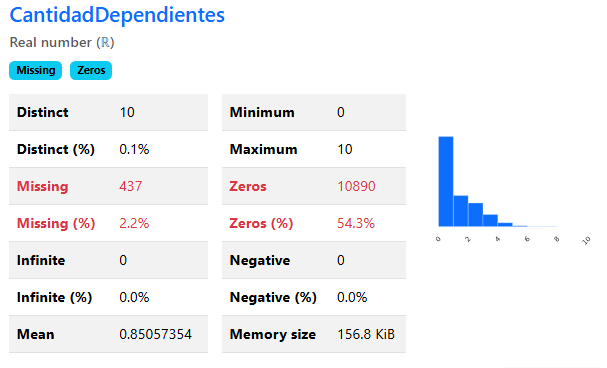
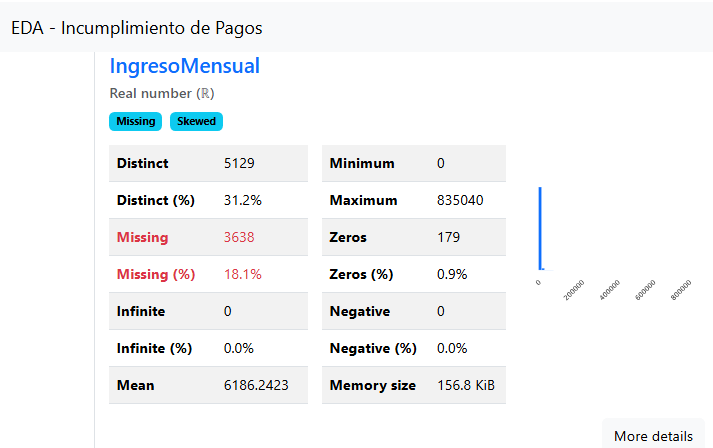

Se ha identificado que las columnas **Cantidad de dependientes** e **Ingresos mensuales** contienen valores nulos. 

* La columna **Cantidad de dependientes** tiene 437 valores nulos, que representan el **2.2%** del total de la base de datos.
* La columna **Ingresos mensuales** presenta 3,638 valores nulos, lo que equivale al **18.1%** de los datos.

Debido a que el porcentaje de datos faltantes en `Ingresos mensuales` es superior al 5%, no se recomienda la eliminación de estas filas para evitar un sesgo en los resultados. Por esta razón, se optará por un método de **imputación de valores**.

En lugar de utilizar métodos simples como la media o la mediana, se ha elegido el algoritmo **K-Nearest Neighbors (KNN)** para la imputación. El método KNN es superior porque considera la relación entre las variables para realizar una estimación más precisa de los valores faltantes.

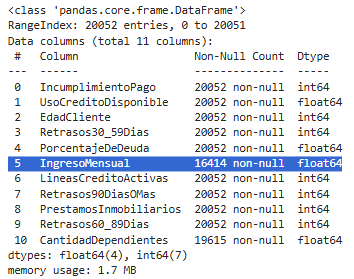

El DataFrame tiene 20,052 registros. Los índices de las filas van desde el 0 hasta el 20051, tenemos un total de 11 columnas 

## Visualizaciones útiles

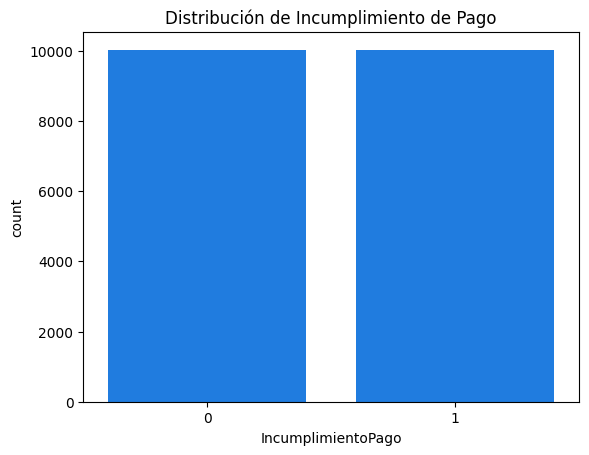

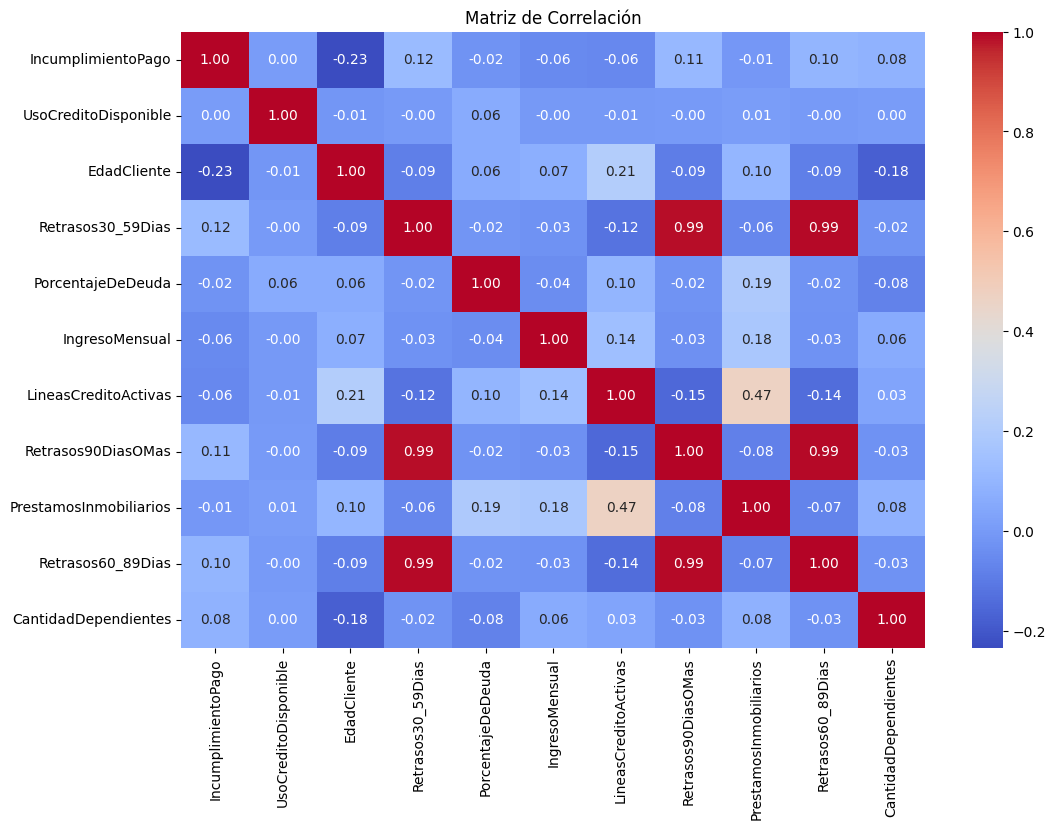

In [6]:
# Distribución de la variable objetivo
sns.countplot(x='IncumplimientoPago', data=df, color='#007BFF')
plt.title("Distribución de Incumplimiento de Pago")
plt.show()

# Correlación
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()

In [8]:
# Selecciono solo numéricas para KNN
numeric_cols = df.select_dtypes(include=np.number).columns
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [9]:
# Verificar ya no tener datos nulos
# Create a new DataFrame from the calculated series
resumen_nulos = pd.DataFrame({
    'Cantidad_Nulos': df.isnull().sum(),
    'Porcentaje_Nulos': (df.isnull().mean() * 100).round(2)   
})

# Add a column for the variable name from the index
resumen_nulos = resumen_nulos.reset_index().rename(columns={'index': 'Variable'})

# Display the new DataFrame
print(resumen_nulos)

                  Variable  Cantidad_Nulos  Porcentaje_Nulos
0       IncumplimientoPago               0               0.0
1     UsoCreditoDisponible               0               0.0
2              EdadCliente               0               0.0
3        Retrasos30_59Dias               0               0.0
4        PorcentajeDeDeuda               0               0.0
5           IngresoMensual               0               0.0
6     LineasCreditoActivas               0               0.0
7       Retrasos90DiasOMas               0               0.0
8   PrestamosInmobiliarios               0               0.0
9        Retrasos60_89Dias               0               0.0
10    CantidadDependientes               0               0.0


In [10]:
#  Detección de outliers (IQR)
def detectar_outliers_iqr(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    return df[(df[columna] < limite_inf) | (df[columna] > limite_sup)]

# Ejemplo: UsoCreditoDisponible
outliers = detectar_outliers_iqr(df, "UsoCreditoDisponible")
print(f"Outliers en UsoCreditoDisponible: {len(outliers)} filas")

# Decisión: no eliminarlos porque pueden ser clientes reales de riesgo

Outliers en UsoCreditoDisponible: 57 filas


### Implemento esta función para detectar valores atípicos (outliers) utilizando el método del rango intercuartílico (IQR). La salida del código indica que se encontraron 57 outliers en la columna UsoCreditoDisponible, pero se decide conservarlas

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=["IncumplimientoPago"]))

In [12]:
# Continuamos con el Modelado
# Pata ello hacemos la preparación de datos
X = df.drop(columns=["IncumplimientoPago"])
y = df["IncumplimientoPago"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
#Aplicamos normalizacion (Escalado)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Definimos nuestros Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42)
}

In [15]:
# Actualizo La Regresión logistica con max_iter mayor
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, class_weight='balanced', solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
}

results = {}

In [16]:
from sklearn.metrics import RocCurveDisplay
import os

os.makedirs("roc_curves", exist_ok=True)

for name, model in models.items():
    print(f"\n Entrenando: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = model.score(X_test, y_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    recall_1 = report.get("1", {}).get("recall", 0.0)
    f1_1 = report.get("1", {}).get("f1-score", 0.0)
    auc = roc_auc_score(y_test, y_prob)

    results[name] = {"Accuracy": acc, "Recall": recall_1, "F1-Score": f1_1, "AUC": auc}
    print(classification_report(y_test, y_pred, zero_division=0))

    # Guardar curva ROC como imagen
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
    plt.title(f"ROC Curve - {name}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid(True)
    filename = f"roc_curves/roc_{name.replace(' ', '_').lower()}.png"
    plt.savefig(filename)
    plt.close()
    print(f" Curva ROC guardada: {filename}")


 Entrenando: Logistic Regression
              precision    recall  f1-score   support

         0.0       0.70      0.79      0.74      2006
         1.0       0.76      0.66      0.70      2005

    accuracy                           0.72      4011
   macro avg       0.73      0.72      0.72      4011
weighted avg       0.73      0.72      0.72      4011

 Curva ROC guardada: roc_curves/roc_logistic_regression.png

 Entrenando: Decision Tree
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70      2006
         1.0       0.70      0.71      0.70      2005

    accuracy                           0.70      4011
   macro avg       0.70      0.70      0.70      4011
weighted avg       0.70      0.70      0.70      4011

 Curva ROC guardada: roc_curves/roc_decision_tree.png

 Entrenando: Random Forest
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.79      2006
         1.0       0.79      0.78

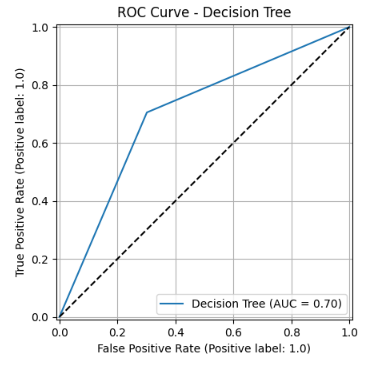
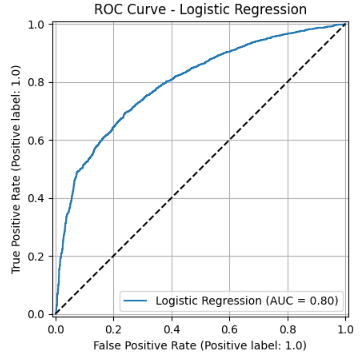
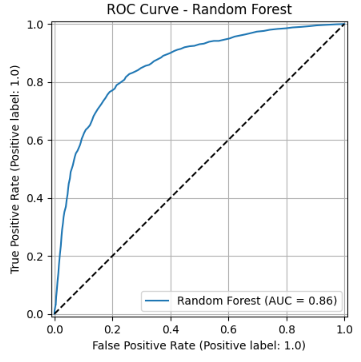

In [21]:
# Tabla comparativa de nuestros modelos
print("\n Resumen de métricas:")
print(pd.DataFrame(results).T.sort_values(by="AUC", ascending=False))


 Resumen de métricas:
                     Accuracy  Recall  F1-Score       AUC
Random Forest        0.784592     0.0       0.0  0.857751
Logistic Regression  0.723510     0.0       0.0  0.796455
Decision Tree        0.701820     0.0       0.0  0.701821


In [24]:
# Extraer los valores de AUC como Series
auc_scores = pd.Series({name: result["AUC"] for name, result in results.items()})
best_model_name = auc_scores.idxmax()
print(f"Mejor modelo: {best_model_name}")

Mejor modelo: Random Forest


In [25]:
# Estrategia para el área comercial
# Implementamos una herramienta de scoring sin necesidad de un científico de datos.
# pa,ra esto exploramos el modelo entrenado
import joblib
joblib.dump(models[best_model_name], "modelo_riesgo.pkl")

['modelo_riesgo.pkl']

In [26]:
# Creación de una función de puntuación
def score_cliente(nuevo_cliente: pd.DataFrame) -> float:
    modelo = joblib.load("modelo_riesgo.pkl")
    return modelo.predict_proba(nuevo_cliente)[:, 1][0]

In [27]:
# Guardo el modelo Entrenado y el escalador
os.makedirs("output", exist_ok=True)
joblib.dump(models[best_model_name], "output/modelo_riesgo.pkl")  #  modelo real
joblib.dump(scaler, "output/scaler.pkl")                         #  escalador
print(" Modelo y escalador guardados en /output/")

 Modelo y escalador guardados en /output/


El paso anterior lo hago con la finalidad de reutilizar sin la necesidad de volver a reentrenar, además de que me permite llevarlo a producción (API, Excel, app, etc.) sin código de entrenamiento.

In [28]:
# FUNCIÓN DE SCORING
def score_cliente(nuevo_cliente: pd.DataFrame) -> float:
    """
    Recibe un DataFrame con una fila del cliente y devuelve el score de riesgo
    """
    model = joblib.load("output/modelo_riesgo.pkl")
    scaler = joblib.load("output/scaler.pkl")
    nuevo_cliente_scaled = scaler.transform(nuevo_cliente)
    return float(model.predict_proba(nuevo_cliente_scaled)[:, 1])

**Usa modelo y escalador para predecir** Esta función nos ayuda a hacerla reproducible
Sin ella, el modelo queda encerrado en el notebook.
Con ella, cualquier sistema o persona puede usarlo.

### Ejemplo:

In [29]:
# Datos de un nuevo cliente 
nuevo = pd.DataFrame([{
    "UsoCreditoDisponible": 0.75,
    "EdadCliente": 35,
    "Retrasos30_59Dias": 2,
    "PorcentajeDeDeuda": 0.30,
    "IngresoMensual": 5000,
    "LineasCreditoActivas": 5,
    "Retrasos90DiasOMas": 0,
    "PrestamosInmobiliarios": 1,
    "Retrasos60_89Dias": 0,
    "CantidadDependientes": 2
}])

riesgo = score_cliente(nuevo)
print(f"Probabilidad de incumplimiento: {riesgo:.2%}")

Probabilidad de incumplimiento: 30.00%


/home/9e16b0a4-46cf-4ed8-a80e-6fb1cbba99a2/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
